# Huygens-Fresnel Principle Based Calculations (HFPBC) for time-efficient creating interference patterns. 

In [1]:
import sys 
import numpy as np
import scipy as sp
from matplotlib import pyplot, transforms
from scipy.signal import argrelextrema, find_peaks
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import itertools
import colorsys
import sk_dsp_comm.sigsys as ss
import mumax3PP.ovf as ovf
import mumax3PP.parameters as parameters
import mumax3PP.fft_across_xyzm as FFT_across_xyzm

sqrt = np.sqrt
pi = np.pi
exp = np.exp
sin = np.sin
cos = np.cos
mu0 = pi*4e-7 # permeability [H/m]

def findNearest(array,value):
    """returns the value and position from 'array' of element closest to 'value'"""
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

def filter_negWaveVectors(M_yx):
    """returns fronts of spin waves with positive wave vector values"""
    M_kq =  np.fft.fft2(M_yx) 
    kLen = int(M_kq.shape[1]/2+1)
    zeros = np.zeros( (M_kq.shape[0], kLen))
    M_kq[:,:kLen] = zeros
    M_yx_filtered = np.fft.ifft2(M_kq)
    M_yx_filtered /= np.amax(np.abs(M_yx_filtered[:, int(M_yx_filtered.shape[1]/2+100)]))
    return M_yx_filtered

def colourMode(mod, phase):
    """returns rgb color-mode of a wavefront"""
    mod = mod/np.amax(mod)
    array1 = np.zeros((phase.shape[0], phase.shape[1], 3))
    for y in range(phase.shape[0]):
        for x in range(phase.shape[1]):
            h = 0.5+phase[y,x]/(2*np.pi)  # angle
            l, s = (mod[y,x]), 1
            array1[y,x] = np.array(colorsys.hls_to_rgb(h, l, s))
    return array1

## Load of a numerical simulation of spin-wave point source propagation.

1) $M(t,r) \in \Re$\
2) frequency filtering: $M(t,r) \rightarrow M(f=f_0,r) \in \mathbb{C}$

Reading folder: point_source_40GHz.out/m_x*.ovf
N of files to process:  110
Available nodes (n-1): 11
Matrix shape: (110, 1, 328, 3000, 1)
(110, 1, 328, 3000, 1)
{'xmin': 0.0, 'ymin': 0.0, 'zmin': 0.0, 'valuedim': 1.0, 'xnodes': 3000.0, 'ynodes': 328.0, 'znodes': 1.0, 'xstepsize': 5e-09, 'ystepsize': 5e-09, 'zstepsize': 5e-09}
1.5e-08 1.568125000000077e-08 6.1931818181888405e-12
(110, 1, 328, 3000, 1)
--> (110, 984000)
Exiting Main Thread
(110, 1, 328, 3000, 1) vs (56, 1, 328, 3000, 1)


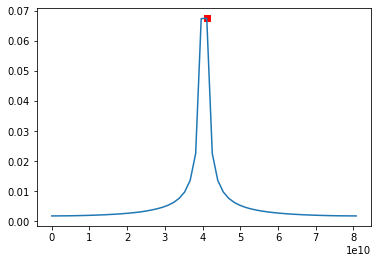

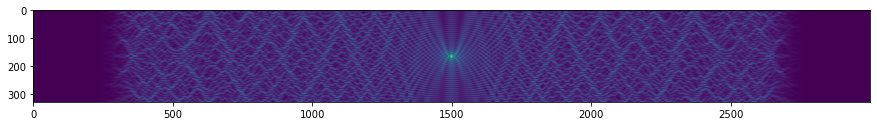

In [4]:
path0 = r"point_source_40GHz.out" # path of spin-wave point source simulation results
parms = parameters.ovfParms(head="m_x") 

M_tzyxm = ovf.OvfFile(path0, parms) # parameters took from ovf-type file

cy = (M_tzyxm._headers)['ystepsize']  # unit cell size in y-direction
cx = (M_tzyxm._headers)['xstepsize']  # unit cell size in x-direction

print((M_tzyxm.array).shape)
print((M_tzyxm._headers))
print(M_tzyxm.time[0], M_tzyxm.time[-1], (-M_tzyxm.time[0]+M_tzyxm.time[-1])/(M_tzyxm.time).shape[0])

# Fast Fourier Transformation (FFT) performed on the simulation data to check the spin waves frequency
M_tzyxm.array, M_tzyxm.time = FFT_across_xyzm.FFT_across_xyzm_threads(M_tzyxm.array, (M_tzyxm.time))
fmr = np.mean( np.abs(M_tzyxm.array), axis=(1,2,3,4) )
fqs_fft = M_tzyxm.time
f_max_i =  findNearest(fmr, fmr.max())[0]

plt.plot(fqs_fft, fmr)
plt.scatter(fqs_fft[f_max_i], fmr[f_max_i], marker='s', color='r')

profil = M_tzyxm.array[f_max_i,0,:,:,0]

plt.figure(figsize=(15,5))
plt.imshow(np.abs(profil))
del(M_tzyxm)

### Filtering of spin waves with a negative wave vector to obtain a half-circular source imitating wave propagation from a single slit.

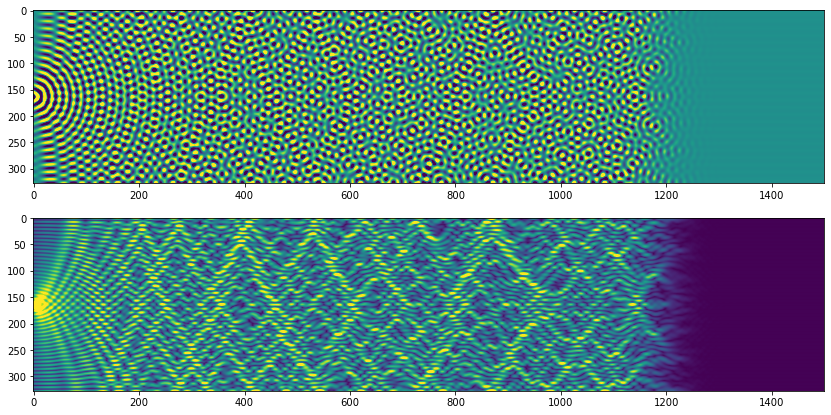

In [5]:
pointSrc0 = filter_negWaveVectors(profil.copy())
pointSrc0 = pointSrc0[:, int(pointSrc0.shape[1]/2):]

plt.figure(figsize=(15,7))
plt.subplot(211)
plt.imshow(np.real(pointSrc0[:,:]), vmin=-0.5, vmax=0.5) # spin waves amplitude
plt.subplot(212)
plt.imshow(np.abs(pointSrc0), vmin=0, vmax=1) # spin waves absolute value
plt.show()

## Aperture function #1

### Creation of an aperture function to freely manipulate its width, position and characteristics of the source.

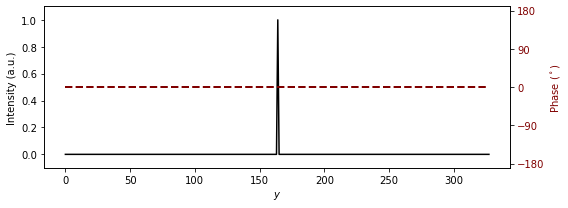

In [66]:
y_int = np.arange(pointSrc0.shape[0])

def aperture_func(yi):
    slitW = 1 # *5[nm] --> width of the aperture
    g_t = np.zeros_like(yi).astype(complex)
    for yi_i in range(len(yi)):
        yi_t = yi[yi_i]
        if yi_t > yi.shape[0]/2-slitW/2 and yi_t < yi.shape[0]/2+slitW/2:
            Amp_t = 1
            phi_t = 0
        else:
            Amp_t = 0.0
            phi_t = 0
        g_t[yi_i] = Amp_t*exp(1j*phi_t )
    return g_t
g_in = aperture_func(y_int)

fig, ax1 = plt.subplots(figsize=(8,3))
ax1.plot(y_int, np.abs(g_in), color='k')
ax1.set_ylim(-0.1, 1.1)
ax1.set_ylabel(r"Intensity (a.u.)")
ax1.set_xlabel(r"$y$")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color_phi = 'maroon'
ax2.plot(y_int, np.angle(g_in)*180/pi, color=color_phi, ls='--', lw=2)
ax2.tick_params(axis='y', labelcolor=color_phi)
ax2.set_ylabel(r"Phase ($^\circ$)", color=color_phi)
ax2.set_ylim(-190, 190)
ax2.set_yticks(range(-180, 190, 90))
fig.tight_layout()  # otherwise the right y-label is slightly clipped

0 / 328
50 / 328
100 / 328
150 / 328
200 / 328
250 / 328
300 / 328


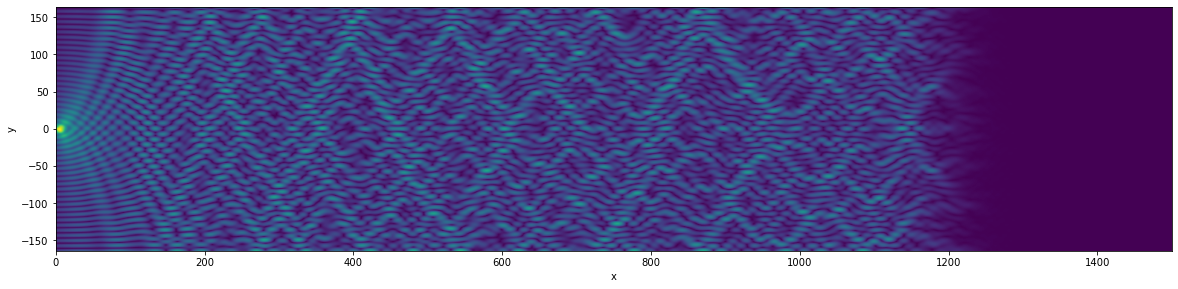

In [67]:
pointSrc = pointSrc0[:,:].copy()
pSrc_Y = pointSrc.shape[0]
newField = np.zeros((pSrc_Y+y_int.shape[0], pointSrc.shape[1])).astype(complex)

# profile creation
for i in range(len(y_int)):
    if i%50==0: print("%i / %i"%(i, len(y_int)))
    newField[i:pSrc_Y+i,:] += pointSrc*g_in[i]  # g_in is a complex function
newField /= np.amax(np.abs(newField))

result_newGIN = [g_in, newField]

xMax, yMax = newField.shape[1], newField.shape[0]
plt.figure(figsize=(20,10))
plt.imshow(np.abs(newField), extent=[0, xMax, -yMax/2, yMax/2], vmin=0, vmax=1, aspect='equal') # spin waves absolute value
plt.ylim(-y_int.shape[0]/2, y_int.shape[0]/2)
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.show()

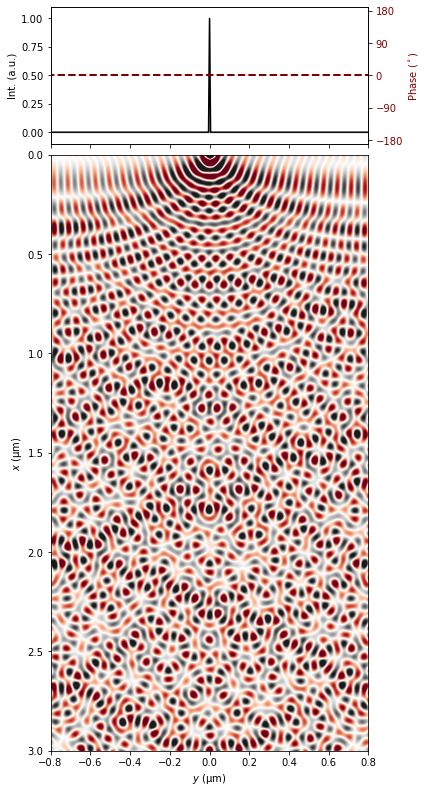

In [69]:
[g_in, arr_in] = result_newGIN

arr_2plot = np.real(arr_in).copy()
arr_2plot /= np.amax(np.abs(arr_2plot[:,20:]))
norm = colors.Normalize(vmin=-0.5, vmax=.5)
cmap="RdGy_r"
x_int, amplitude, phase = y_int, np.abs(g_in), np.angle(g_in)*180/pi

f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 10]}, 
                             sharex=True, figsize=(6, 16))
sh = arr_2plot.shape
y_li = np.arange( -sh[0]/2 *cy, sh[0]/2*cy, cy)*1e06
x_li = np.arange( 0, sh[1]*cx, cx)*1e06
ax1.imshow(arr_2plot.T, norm=norm, cmap=cmap, origin="upper",
          extent=[y_li[0], y_li[-1], x_li[-1], x_li[0],],   )
ax1.axvline(-3, color='w', lw=0.5)
ax1.axvline( 3, color='w', lw=0.5)
y_interface = (x_int-y_int.shape[0]/2)*cy*1e06
ax0.plot(y_interface, amplitude, color='k')
ax0.fill_between(y_interface, 0, amplitude, color='#CCCCCC')
ax0.set_ylim(-0.1, 1.1)
ax0.set_ylabel(r"Int. (a.u.)")

ax0a = ax0.twinx()  # instantiate a second axes that shares the same x-axis
color_phi = 'maroon'
ax0a.plot(y_interface, phase, color=color_phi, ls='--', lw=2) # spin waves phase map
ax0a.tick_params(axis='y', labelcolor=color_phi)
ax0a.set_ylabel(r"Phase ($^\circ$)", color=color_phi)
ax0a.set_ylim(-190, 190)
ax0a.set_yticks(range(-180, 190, 90))

ax1.set_xlabel(r"$y$ ($\mathrm{\mu m}$)")
ax1.set_ylabel(r"$x$ ($\mathrm{\mu m}$)")
f.subplots_adjust(wspace=0.0, hspace=0.0)
    
ax1.set_xlim(-0.8, 0.8)
ax1.set_ylim(3, 0)
f.tight_layout(h_pad=-30)

## Aperture function #2

### wider aperture

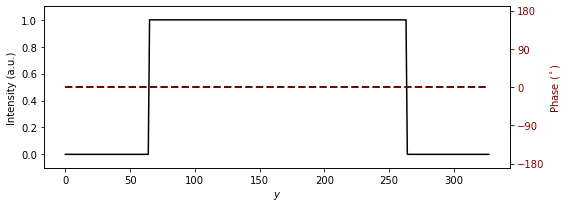

In [70]:
y_int = np.arange(pointSrc0.shape[0])

def aperture_func(yi):
    slitW = 200 # *5[nm] --> width of the aperture
    g_t = np.zeros_like(yi).astype(complex)
    for yi_i in range(len(yi)):
        yi_t = yi[yi_i]
        if yi_t > yi.shape[0]/2-slitW/2 and yi_t < yi.shape[0]/2+slitW/2:
            Amp_t = 1
            phi_t = 0
        else:
            Amp_t = 0.0
            phi_t = 0
        g_t[yi_i] = Amp_t*exp(1j*phi_t)
    return g_t

g_in = aperture_func(y_int)

fig, ax1 = plt.subplots(figsize=(8,3))
ax1.plot(y_int, np.abs(g_in), color='k')
ax1.set_ylim(-0.1, 1.1)
ax1.set_ylabel(r"Intensity (a.u.)")
ax1.set_xlabel(r"$y$")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color_phi = 'maroon'
ax2.plot(y_int, np.angle(g_in)*180/pi, color=color_phi, ls='--', lw=2)
ax2.tick_params(axis='y', labelcolor=color_phi)
ax2.set_ylabel(r"Phase ($^\circ$)", color=color_phi)
ax2.set_ylim(-190, 190)
ax2.set_yticks(range(-180, 190, 90))
fig.tight_layout()  # otherwise the right y-label is slightly clipped

0 / 328
50 / 328
100 / 328
150 / 328
200 / 328
250 / 328
300 / 328


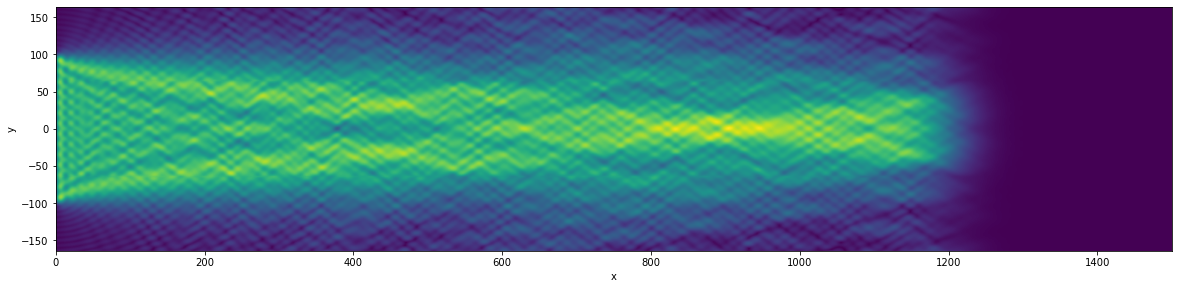

In [71]:
pointSrc = pointSrc0[:,:].copy()

pSrc_Y = pointSrc.shape[0]
newField = np.zeros((pSrc_Y+y_int.shape[0], pointSrc.shape[1])).astype(complex)

# profile creating
for i in range( len(y_int)):
    if i%50==0: print("%i / %i"%(i, len(y_int)))
    newField[i:pSrc_Y+i,:] += pointSrc*g_in[i]  # g_in is complex function
newField /= np.amax(np.abs(newField))

xMax, yMax = newField.shape[1], newField.shape[0]
plt.figure(figsize=(20,10))
plt.imshow(np.abs(newField), extent=[0, xMax, -yMax/2, yMax/2], vmin=0, vmax=1, aspect='equal') # spin waves absolute value
plt.ylim(-y_int.shape[0]/2, y_int.shape[0]/2)
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.show()

result_newGIN = [g_in, newField]

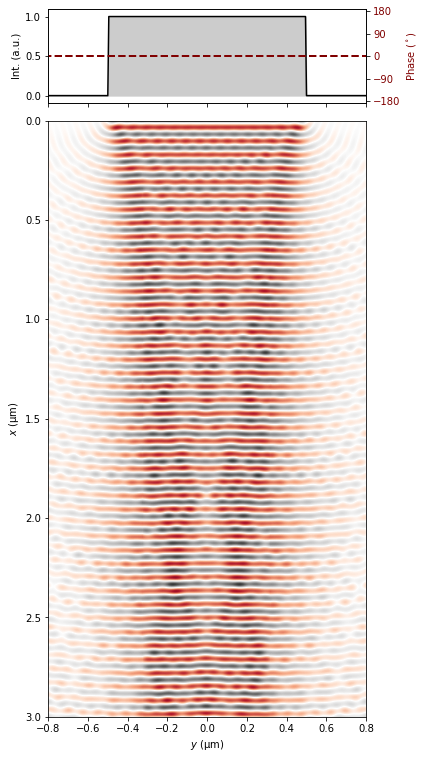

In [72]:
[g_in, arr_in] = result_newGIN

arr_2plot = np.real(arr_in).copy()
arr_2plot /= np.amax(np.abs(arr_2plot[:,20:]))
norm = colors.Normalize(vmin=-1, vmax=1)
cmap="RdGy_r"
x_int, amplitude, phase = y_int, np.abs(g_in), np.angle(g_in)*180/pi
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 10]}, 
                             sharex=True, figsize=(6, 13))

sh = arr_2plot.shape
y_li = np.arange( -sh[0]/2 *cy, sh[0]/2*cy, cy)*1e06
x_li = np.arange( 0, sh[1]*cx, cx)*1e06
ax1.imshow(arr_2plot.T, norm=norm, cmap=cmap, origin="upper",
          extent=[y_li[0], y_li[-1], x_li[-1], x_li[0],],   )
ax1.axvline(-3, color='w', lw=0.5)
ax1.axvline( 3, color='w', lw=0.5)
ax1.set_xlim(-9, 9)
ax1.set_ylim(12, 0)


y_interface = (x_int-y_int.shape[0]/2)*cy*1e06
ax0.plot(y_interface, amplitude, color='k')
ax0.fill_between(y_interface, 0, amplitude, color='#CCCCCC')
ax0.set_ylim(-0.1, 1.1)
ax0.set_ylabel(r"Int. (a.u.)")

ax0a = ax0.twinx()  # instantiate a second axes that shares the same x-axis
color_phi = 'maroon'
ax0a.plot(y_interface, phase, color=color_phi, ls='--', lw=2) # spin waves phase map
ax0a.tick_params(axis='y', labelcolor=color_phi)
ax0a.set_ylabel(r"Phase ($^\circ$)", color=color_phi)
ax0a.set_ylim(-190, 190)
ax0a.set_yticks(range(-180, 190, 90))

ax1.set_xlabel(r"$y$ ($\mathrm{\mu m}$)")
ax1.set_ylabel(r"$x$ ($\mathrm{\mu m}$)")
f.subplots_adjust(wspace=0.0, hspace=0.0)
    
ax1.set_xlim(-0.8, 0.8)
ax1.set_ylim(3, 0)
f.tight_layout(h_pad=-16)

## Periodic apertures function

### A program that returns a series of periodically arranged circular sources as defined above. Using the HFPBC method, we will recreate the interference pattern of wave fronts coming from any given aperture's:  
- number, 
- period,
- width,
- shape, etc.

C:\Users\matig\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


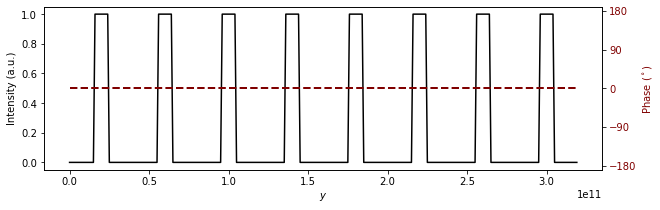

In [73]:
l = 320 #*5 nm - width of a waveguide
s = 8 # *5 nm - aperture width
n = 8 # number of apertures
w2 = 0 # *5 nm - shift 
d = int(l/n)
y_int = np.arange(0, l, 1)
g_in = ss.rect(np.mod(y_int, d)-d/2, s)

src = []
for i in range(int(np.floor(l/d))):
        source_n = (i-1)*d+d/2-s/2
        src.append(source_n)

shift_src = 0
g_in_an = np.zeros_like(y_int).astype(complex)

for i in range(len(y_int)):
    if y_int[i] <= w2 or y_int[i] >= l - w2:
        Amp = 0
    else:
        Amp = 1
    if y_int[i] >= src[shift_src] and y_int[i] <= src[shift_src] + s:
        phi_t = pi/4
    else:
        phi_t = 0
    g_in_an[i] = Amp*g_in[i]*exp(1j*phi_t)

fig, ax1 = plt.subplots(figsize=(10,3))
ax1.plot(y_int*1e09, g_in_an, color='k')
ax1.set_ylabel(r"Intensity (a.u.)")
ax1.set_xlabel(r"$y$")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color_phi = 'maroon'
ax2.plot(y_int*1e09, np.angle(g_in_an)*180/pi, color=color_phi, ls='--', lw=2)
ax2.tick_params(axis='y', labelcolor=color_phi)
ax2.set_ylabel(r"Phase ($^\circ$)", color=color_phi)
ax2.set_ylim(-190, 190)
ax2.set_yticks(range(-180, 190, 90))

g_in = g_in_an

0 / 320
50 / 320
100 / 320
150 / 320
200 / 320
250 / 320
300 / 320


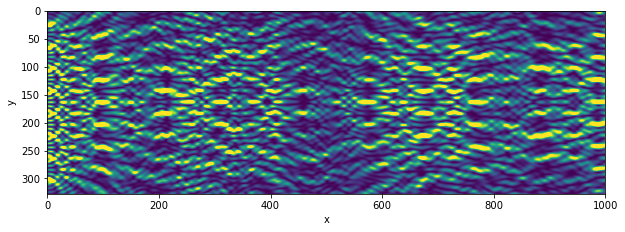

In [75]:
pointSrc = pointSrc0[:,:].copy()

pSrc_Y = pointSrc.shape[0]
newField = np.zeros((pSrc_Y+y_int.shape[0], pointSrc.shape[1])).astype(complex)

# profile creating
for i in range(len(y_int)):
    if i%50==0: print("%i / %i"%(i, len(y_int)))
    newField[i:pSrc_Y+i,:] += pointSrc*g_in[i] # g_in is complex function
newField /= np.amax(np.abs(newField))
newField = newField[int(len(y_int)/2):-int(len(y_int)/2),:]

norm = colors.Normalize(vmin=0, vmax=.3)
plt.figure(figsize=(10,10))
test = np.real(newField[:,:])**2 + np.imag(newField[:,:])**2 # spin waves intensity
plt.imshow(test, norm=norm)
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.xlim(0,1000) 
result_newGIN = [g_in, newField]

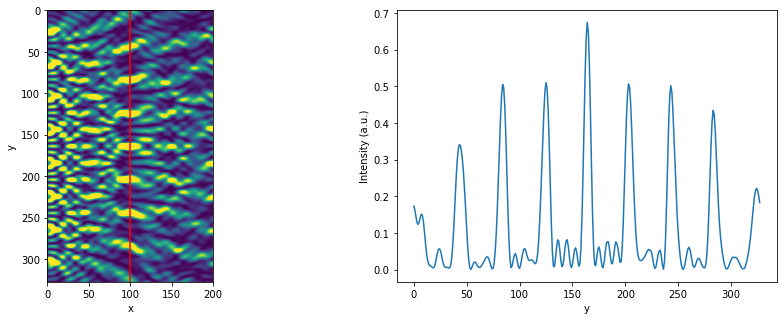

In [78]:
f=plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(test, norm=norm) # 2D spin waves intensity
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.xlim(0,200)
plt.axvline(100, color='r')
plt.subplot(122)
plt.plot(test[:,100]) # 1D spin waves intensity
plt.xlabel(r"y")
plt.ylabel(r"Intensity (a.u.)")
plt.show()

# Lookup tables (LUT) functionality

### Returns all possible configurations of binary inputs depending on their number and converts the input signal nomenclature according to the scheme:
when we have, e.g. 3 inputs:  
[1] means that only in the first one we have logical '1', i.e. [1,0,0]  
analogously:  
[2] --> [0,1,0]  
[1,2] --> [1,1,0]  
[1,2,3] --> [1,1,1] etc.

In [26]:
def inputs_combinations(number_of_inputs):
    """returns all binary combinantions from the 'number_of_inputs' variables"""
    all_combinations_digit = []
    all_combinations_numb = []
    a_list = []
    
    for i in range(number_of_inputs):
        a_list.append(i+1)

    for r in range(len(a_list)+1):
        combinations_object = itertools.combinations(a_list, r)
        combinations_list = list(combinations_object)
        all_combinations_numb+=combinations_list
    all_combinations_numb=all_combinations_numb[1:]
    
    for i in range(len(all_combinations_numb)):
        if len(all_combinations_numb[i])==1:
            all_combinations_numb[i]=(all_combinations_numb[i][0])

    for i in range(len(all_combinations_numb)):
        inputs = [0]*number_of_inputs
        if type(all_combinations_numb[i])==int:
            inputs[all_combinations_numb[i]-1]=1
            all_combinations_numb[i] = [all_combinations_numb[i]]
        else:
            for j in range(len(list(all_combinations_numb[i]))):
                inputs[list(all_combinations_numb[i])[j]-1]=1
                all_combinations_numb[i] = list(all_combinations_numb[i])
        all_combinations_digit.append(inputs)
        
    return all_combinations_digit, all_combinations_numb

In [27]:
number_of_inputs = 4
L = len(inputs_combinations(number_of_inputs)[0])
for i in range(L):
        print(inputs_combinations(number_of_inputs)[1][i],' --------> ',\
              inputs_combinations(number_of_inputs)[0][i])

[1]  -------->  [1, 0, 0, 0]
[2]  -------->  [0, 1, 0, 0]
[3]  -------->  [0, 0, 1, 0]
[4]  -------->  [0, 0, 0, 1]
[1, 2]  -------->  [1, 1, 0, 0]
[1, 3]  -------->  [1, 0, 1, 0]
[1, 4]  -------->  [1, 0, 0, 1]
[2, 3]  -------->  [0, 1, 1, 0]
[2, 4]  -------->  [0, 1, 0, 1]
[3, 4]  -------->  [0, 0, 1, 1]
[1, 2, 3]  -------->  [1, 1, 1, 0]
[1, 2, 4]  -------->  [1, 1, 0, 1]
[1, 3, 4]  -------->  [1, 0, 1, 1]
[2, 3, 4]  -------->  [0, 1, 1, 1]
[1, 2, 3, 4]  -------->  [1, 1, 1, 1]


## LUT function -- SYMMETRIC CONFIGURATION (inputs: [1,8], controls: [2-7])

In [28]:
def lookup_table_symm(number_of_sources, distance_between_apertures, aperture_width, number_of_input, shift_input, shift_control, amplitude_input, amplitude_control, axhline, threshhold, plots=bool):
    
    """returns phase and intensity plots of spin waves interference pattern together with the output binary result measured from self-images intensity"""
    
    """
    Arguments:
    1) "number_of_sources" - number of spin waves sources creating the Talbot interference pattern
    2) "distance_between_apertures" - distance between inputs / period of diffraction grating [nm]
    3) "aperture_width" - single input width [nm]
    4) "number_of_input" - number ([1] or [8] or both [1,8] or none [0]) of input to change (encode information)
    5) "shift_input" - phase change of the chosen ("number_of_input") input(s) [rad]
    6) "shift_control" - phase change of the control inputs ([2,3,4,5,6,7]) [rad]
    7) "amplitude_input" - amplitude change of the chosen ("number_of_input") input(s) (if 1 --> unchanged)
    8) "amplitude_control" - amplitude change of the control inputs
    9) "axhline" - distance from the sources to be analysed as the output (self-images) [nm]
    10) "threshhold" - the normalised intensity above which we interpret the logical '1'
    11) "plots" - boolean, if True the function displays the plots, if False it returns only the output binary result
    """   
        
    if(distance_between_apertures%5!=0 or aperture_width%5!=0 or axhline%5!=0):
        sys.exit("All length parameters must be divisible by 5, because the unit cell is 5 nm.")
    else:
        pass
    
    number_of_sources2 = number_of_sources
    distance_between_apertures2 = distance_between_apertures
    aperture_width2 = aperture_width
    axhline2 = axhline
    plots2 = plots

#------------------------------------------------------------------------------------------------------------------------
    
    def ref_input(number_of_sources2, distance_between_apertures2, aperture_width2, axhline2, plots2 = bool):
        """Reference signal, i.e. input: [0,0,0]"""
        pointSrc0 = filter_negWaveVectors(profil.copy())
        pointSrc0 = pointSrc0[:, int(pointSrc0.shape[1]/2):]

        d = distance_between_apertures/5
        s = aperture_width/5
        n = number_of_sources
        width = d*n
        y_int = np.arange(0, width, 1)

        g_in = ss.rect(np.mod(y_int, d)-d/2, s)

        src = []
        for i in range(n+1):
                source_n = (i-1)*d+d/2-s/2
                src.append(source_n)

        pointSrc = pointSrc0[:,:].copy()
        pSrc_Y = pointSrc.shape[0]
        newField = np.zeros((pSrc_Y+y_int.shape[0], pointSrc.shape[1])).astype(complex)

        for i in range(len(y_int)):
            newField[i:pSrc_Y+i,:] += pointSrc*g_in[i]

        newField /= np.amax(np.abs(newField))
        newField2 = np.real(newField[:,:])**2 + np.imag(newField[:,:])**2
        newField2 = newField2[int(pSrc_Y/2):int(-pSrc_Y/2),:]
        newField2 = newField2[:,:200]
        result_newGIN = [g_in, newField, newField2]  
        [g_in, arr_in, intensity] = result_newGIN

        int_2plot = intensity.copy()
        int_2plot /= np.amax(np.abs(int_2plot[:,20:]))
        sh = int_2plot.shape
        axhl = int(axhline/5)

        return np.mean(int_2plot[:,axhl-10:axhl+10], axis=1)

#------------------------------------------------------------------------------------------------------------------------
            
    pointSrc0 = filter_negWaveVectors(profil.copy())
    pointSrc0 = pointSrc0[:, int(pointSrc0.shape[1]/2):]
    
    d = distance_between_apertures/5
    s = aperture_width/5
    n = number_of_sources
    width = d*n
    y_int = np.arange(0, width, 1)

    g_in = ss.rect(np.mod(y_int, d)-d/2, s)

    src = []
    for i in range(n+1):
            source_n = (i-1)*d+d/2-s/2
            src.append(source_n)

    g_in_an = np.zeros_like(y_int).astype(complex)
    
    b = 1
    Amp=0
    phi_t=0
    for i in range(len(y_int)):
        
        if g_in[i]==1 and (b==1 or b==n) and (b not in number_of_input):
            Amp=1
            phi_t=0          
            if g_in[i+1]==0:
                b+=1
            else:
                b=b
                
        elif g_in[i]==1 and (b in number_of_input):
            phi_t = shift_input
            Amp = amplitude_input
            
            if g_in[i+1]==0:
                b+=1
            else:
                b=b
            
        elif g_in[i]==1 and (b not in number_of_input) and (b!=1 and b!=n):
            phi_t = shift_control
            Amp = amplitude_control
            
            if g_in[i+1]==0:
                b+=1
            else:
                b=b
        else:
            Amp=1
            phi_t=0  
            
        g_in_an[i] = Amp*g_in[i]*exp(1j*phi_t)    

    g_in = g_in_an
    pointSrc = pointSrc0[:,:].copy()

    pSrc_Y = pointSrc.shape[0]
    newField = np.zeros((pSrc_Y+y_int.shape[0], pointSrc.shape[1])).astype(complex)

    for i in range(len(y_int)):
        newField[i:pSrc_Y+i,:] += pointSrc*g_in[i]
        
    newField /= np.amax(np.abs(newField))
    newField2 = np.real(newField[:,:])**2 + np.imag(newField[:,:])**2
    newField = newField[int(pSrc_Y/2):int(-pSrc_Y/2),:]
    newField2 = newField2[int(pSrc_Y/2):int(-pSrc_Y/2),:]
    newField = newField[:,:200]
    newField2 = newField2[:,:200]
    result_newGIN = [g_in, newField, newField2]
 
 # -------------------------------FIGURES-----------------------------------------------
    
    [g_in, arr_in, intensity] = result_newGIN
    
    phase_2plot = np.angle(newField).copy()
    mod_2plot = np.abs(newField).copy()
    
    arr_2plot = np.real(arr_in).copy()
    arr_2plot /= np.amax(np.abs(arr_2plot[:,20:]))
    int_2plot = intensity.copy()
    int_2plot /= np.amax(np.abs(int_2plot[:,20:]))
    norm_re = colors.Normalize(vmin=-0.5, vmax=.5)
    norm_int = colors.Normalize(vmin=0, vmax=1)
    cmap="RdGy_r"
    color_phi = 'maroon'
    x_int, amplitude, phase = y_int, np.abs(g_in), np.angle(g_in)*180/pi
    amplitude /= np.amax(amplitude)
    sh = arr_2plot.shape
    y_li = np.arange( 0, sh[0]*cy, cy)*1e09
    x_li = np.arange( 0, sh[1]*cx, cx)*1e09
    axhl = int(axhline/5)
    i=0
    
    f, ax = plt.subplots(2, 2, sharex=True, gridspec_kw={'height_ratios': [1, 5]}, figsize=(15, 8))

    ax[0,0].plot(x_int*5, amplitude, color='k')
    ax[0,0].fill_between(x_int*5, 0, amplitude, color='#CCCCCC')
    ax[0,0].set_ylim(-0.1, 1.1)
    ax[0,0].set_ylabel(r"Ampl. (a.u.)")
    ax0a = ax[0,0].twinx()
    ax0a.plot(x_int*5, phase, color=color_phi, ls='-', lw=4)
    ax0a.tick_params(axis='y', labelcolor=color_phi)
    ax0a.set_ylabel(r"Phase ($^\circ$)", color=color_phi)
    ax0a.set_ylim(-190, 190)
    ax0a.set_yticks(range(-180, 190, 90))
    
    ax[1,0].imshow(colourMode(mod_2plot.T,phase_2plot.T), norm=norm_re, cmap=cmap, origin="upper",\
                   aspect = 'auto', extent=[y_li[0], y_li[-1], x_li[-1], x_li[0],])
    ax[1,0].set_xlabel(r"$x$ ($\mathrm{nm}$)")
    ax[1,0].set_ylabel(r"$y$ ($\mathrm{nm}$)")


    intentsity_1d_x = np.arange(0, sh[0], 1)
    int_avg = np.mean(int_2plot[:,axhl-15:axhl+15], axis=1)
    
    ax[0,1].plot(intentsity_1d_x*5, int_avg[:], linewidth = 3, color = 'blue')
    ax[0,1].plot(intentsity_1d_x*5, ref_input(8, 200, 40, 480, True), alpha =0.7, color = 'green')
    ax[0,1].set_ylabel(r"Ampl. (a.u.)")
    ax[0,1].axhline(threshhold, color = 'orange', ls='--')
    max_i = find_peaks(int_avg[:], height=threshhold)[0]
    
    for i in range(len(max_i)):
        j = np.array(max_i[i])
        ax[0,1].scatter(j*5, int_avg[j], zorder=3, color='red')
        
    truth_table = []
    m = False
    for i in range(n):
        for j in range(len(max_i)):
            if np.abs(i*d - max_i[j]) < 5:
                m = True
            else:
                pass

        if m:
            truth_table.append(1)
            m = False
        else:
            truth_table.append(0)
            m = False
    
    ax[1,1].imshow(int_2plot.T, norm=norm_int, aspect = 'auto', 
                   extent=[y_li[0], y_li[-1], x_li[-1], x_li[0],])
    ax[1,1].axhline(axhline, color = 'red',lw=20, alpha = 0.4)
    ax[1,1].set_xlabel(r"$x$ ($\mathrm{nm}$)")
    ax[1,1].set_ylabel(r"$y$ ($\mathrm{nm}$)")

    f.subplots_adjust(wspace=.3, hspace=0.05)
    
    if plots == True:
        plt.show()
    else:
        plt.close()
    
    del(truth_table[0])
    del(truth_table[0])
    del(truth_table[-1])
    return truth_table

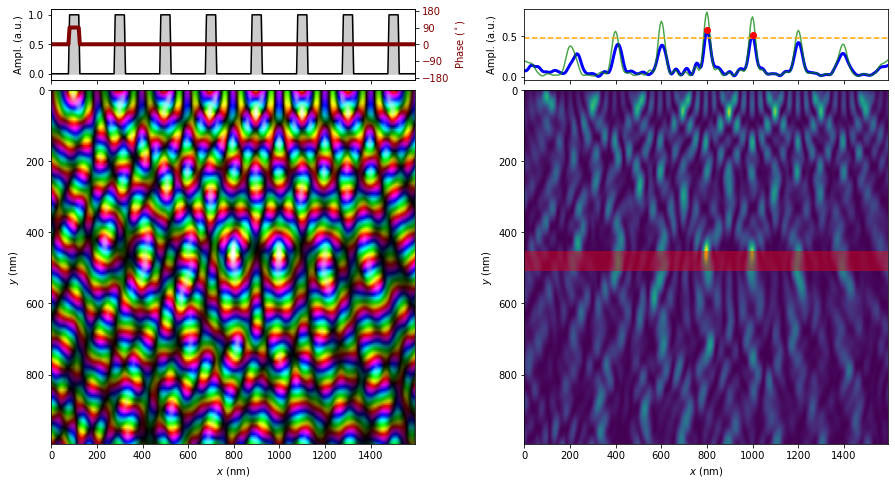

[0, 0, 1, 1, 0]

In [29]:
lookup_table_symm(8, 200, 40, [1], pi/2, 0, 1, 1, 480, 0.48, True)
# 1) number of inputs
# 2) distance between inputs [nm]
# 3) inputs width [nm]
# 4) number (in sequence) of input to change
# 5) phase change of the chosen input [rad]
# 6) phase change of controls
# 7) amplitude change of the chosen input (if 1 --> unchanged)
# 8) amplitude change of controls
# 9) distance from inputs to analysis (#outputs = #inputs-1) [nm]
# 10) threshhold amplitude (a.u. --> from 0 to 1)
# 11) display plots (True) or just a truth table (False)

### 3 inputs (2 main and 1 control), 5 outputs configuration (as in the paper)

In [32]:
def lookup_table_1_8_C(I1_I2_C):
    [I1,I2,C] = I1_I2_C
    return lookup_table_symm(8, 200, 40, [1*I1,8*I2], 0, 0, 0.5, 1-0.5*C, 480, 0.47, False)

In [33]:
number_of_inputs = 3
for i in range(len(inputs_combinations(number_of_inputs)[0])):
    output = lookup_table_1_8_C(inputs_combinations(number_of_inputs)[0][i])
    if inputs_combinations(number_of_inputs)[0][i][2]==0:
        print(i+1,')   ',inputs_combinations(number_of_inputs)[0][i],' --------> ',output)
    else:
        print(i+1,')                                                 ',inputs_combinations(number_of_inputs)[0][i],\
              ' --------> ',output)

1 )    [1, 0, 0]  -------->  [0, 1, 1, 1, 1]
2 )    [0, 1, 0]  -------->  [1, 1, 1, 1, 0]
3 )                                                  [0, 0, 1]  -------->  [1, 1, 1, 1, 1]
4 )    [1, 1, 0]  -------->  [0, 1, 1, 1, 0]
5 )                                                  [1, 0, 1]  -------->  [0, 0, 1, 1, 1]
6 )                                                  [0, 1, 1]  -------->  [1, 1, 1, 1, 0]
7 )                                                  [1, 1, 1]  -------->  [1, 1, 1, 1, 1]


[ Inupt 1, Inuput 2, Control ]

C = 0 &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; C = 1 <br>
[1,1] ---> [0, 0, 1, 0, 0] &emsp;&emsp;&emsp;&emsp; [1,1] --->  [1, 1, 1, 1, 1] <br>
[1,0] ---> [0, 0, 1, 1, 0] &emsp;&emsp;&emsp;&emsp; [1,0] --->  [1, 1, 1, 1, 0] <br>
[0,1] ---> [0, 0, 1, 0, 0] &emsp;&emsp;&emsp;&emsp; [0,1] --->  [0, 1, 1, 1, 1] <br>
[0,0] ---> [1, 1, 1, 1, 1] &emsp;&emsp;&emsp;&emsp; [0,0] --->  [0, 1, 1, 1, 0] <br>
False, NOR, True, ¬I2, False &emsp;&emsp;&emsp;&emsp; ¬I1, True, True, True, I2

## LUT function -- ASYMMETRIC CONFIGURATION (inputs: [2,3], controls: [4, 5, 6])

In [34]:
def lookup_table_asymm(number_of_sources, distance_between_apertures, aperture_width, number_of_input, shift_input, shift_control, amplitude_input, amplitude_control, axhline, threshhold, plots = bool):
    
    """returns phase and intensity plots of spin waves interference pattern together with the output binary result measured from self-images intensity"""
    
    """
    Arguments:
    1) "number_of_sources" - number of spin waves sources creating the Talbot interference pattern
    2) "distance_between_apertures" - distance between inputs / period of diffraction grating [nm]
    3) "aperture_width" - single input width [nm]
    4) "number_of_input" - number ([2] or [3] or both [2,3] or none [0]) of input to change (encode information)
    5) "shift_input" - phase change of the chosen ("number_of_input") input(s) [rad]
    6) "shift_control" - phase change of the control inputs ([4,5,6]) [rad]
    7) "amplitude_input" - amplitude change of the chosen ("number_of_input") input(s) (if 1 --> unchanged)
    8) "amplitude_control" - amplitude change of the control inputs
    9) "axhline" - distance from the sources to be analysed as the output (self-images) [nm]
    10) "threshhold" - the normalised intensity above which we interpret the logical '1'
    11) "plots" - boolean, if True the function displays the plots, if False it returns only the output binary result
    """   
        
    if(distance_between_apertures%5!=0 or aperture_width%5!=0 or axhline%5!=0):
        sys.exit("All length parameters must be divisible by 5, because the unit cell is 5 nm.")
    else:
        pass
    
    number_of_sources2 = number_of_sources
    distance_between_apertures2 = distance_between_apertures
    aperture_width2 = aperture_width
    axhline2 = axhline
    plots2 = plots
    
#------------------------------------------------------------------------------------------------------------------------
    
    def ref_input(number_of_sources2, distance_between_apertures2, aperture_width2, axhline2, plots2 = bool):
        """Reference signal, i.e. input: [0,0,0]"""
        pointSrc0 = filter_negWaveVectors(profil.copy())
        pointSrc0 = pointSrc0[:, int(pointSrc0.shape[1]/2):]

        d = distance_between_apertures/5
        s = aperture_width/5
        n = number_of_sources
        width = d*n
        y_int = np.arange(0, width, 1)

        g_in = ss.rect(np.mod(y_int, d)-d/2, s)


        src = []
        for i in range(n+1):
                source_n = (i-1)*d+d/2-s/2
                src.append(source_n)

        pointSrc = pointSrc0[:,:].copy()

        pSrc_Y = pointSrc.shape[0]
        newField = np.zeros((pSrc_Y+y_int.shape[0], pointSrc.shape[1])).astype(complex)

        for i in range(len(y_int)):
            newField[i:pSrc_Y+i,:] += pointSrc*g_in[i]

        newField /= np.amax(np.abs(newField))
        newField2 = np.real(newField[:,:])**2 + np.imag(newField[:,:])**2
        newField2 = newField2[int(pSrc_Y/2):int(-pSrc_Y/2),:]
        newField2 = newField2[:,:200]
        result_newGIN = [g_in, newField, newField2]  
        [g_in, arr_in, intensity] = result_newGIN

        int_2plot = intensity.copy()
        int_2plot /= np.amax(np.abs(int_2plot[:,20:]))
        sh = int_2plot.shape
        axhl = int(axhline/5)

        return np.mean(int_2plot[:,axhl-10:axhl+10], axis=1)

#------------------------------------------------------------------------------------------------------------------------
            
    pointSrc0 = filter_negWaveVectors(profil.copy())
    pointSrc0 = pointSrc0[:, int(pointSrc0.shape[1]/2):]
    
    d = distance_between_apertures/5
    s = aperture_width/5
    n = number_of_sources
    width = d*n
    y_int = np.arange(0, width, 1)

    g_in = ss.rect(np.mod(y_int, d)-d/2, s)

    src = []
    for i in range(n+1):
            source_n = (i-1)*d+d/2-s/2
            src.append(source_n)

    g_in_an = np.zeros_like(y_int).astype(complex)
    
    b = 1
    Amp=0
    phi_t=0
    input1 = 2
    input2 = 3
    
    for i in range(len(y_int)):
        
        if g_in[i]==1 and (b==input1 or b==input2) and (b not in number_of_input):
            Amp=1
            phi_t=0          
            if g_in[i+1]==0:
                b+=1
            else:
                b=b
                
        elif g_in[i]==1 and (b in number_of_input):
            phi_t = shift_input
            Amp = amplitude_input
            
            if g_in[i+1]==0:
                b+=1
            else:
                b=b
            
        elif g_in[i]==1 and (b not in number_of_input) and (b!=input1 and b!=input2 and (b==1 or b==8)):
            phi_t = 0
            Amp = 1
            if g_in[i+1]==0:
                b+=1
            else:
                b=b
            
        elif g_in[i]==1 and (b not in number_of_input) and (b!=input1 and b!=input2 and (b==4 or b==5 or b==6 or b==7)):
            phi_t = shift_control
            Amp = amplitude_control
            
            if g_in[i+1]==0:
                b+=1
            else:
                b=b
        else:
            Amp=1
            phi_t=0  
            
        g_in_an[i] = Amp*g_in[i]*exp(1j*phi_t)    

    g_in = g_in_an
    pointSrc = pointSrc0[:,:].copy()

    pSrc_Y = pointSrc.shape[0]
    newField = np.zeros((pSrc_Y+y_int.shape[0], pointSrc.shape[1])).astype(complex)

    for i in range(len(y_int)):
        newField[i:pSrc_Y+i,:] += pointSrc*g_in[i]
        
    newField /= np.amax(np.abs(newField))
    newField2 = np.real(newField[:,:])**2 + np.imag(newField[:,:])**2
    newField = newField[int(pSrc_Y/2):int(-pSrc_Y/2),:]
    newField2 = newField2[int(pSrc_Y/2):int(-pSrc_Y/2),:]
    newField = newField[:,:200]
    newField2 = newField2[:,:200]
    result_newGIN = [g_in, newField, newField2]
 
 # --------------------FIGURES----------------------------------------------
    
    [g_in, arr_in, intensity] = result_newGIN
    
    phase_2plot = np.angle(newField).copy()
    mod_2plot = np.abs(newField).copy()
    
    arr_2plot = np.real(arr_in).copy()
    arr_2plot /= np.amax(np.abs(arr_2plot[:,20:]))
    int_2plot = intensity.copy()
    int_2plot /= np.amax(np.abs(int_2plot[:,20:]))
    norm_re = colors.Normalize(vmin=-0.5, vmax=.5)
    norm_int = colors.Normalize(vmin=0, vmax=1)
    cmap="RdGy_r"
    color_phi = 'maroon'
    x_int, amplitude, phase = y_int, np.abs(g_in), np.angle(g_in)*180/pi
    amplitude /= np.amax(amplitude)
    sh = arr_2plot.shape
    y_li = np.arange( 0, sh[0]*cy, cy)*1e09
    x_li = np.arange( 0, sh[1]*cx, cx)*1e09
    axhl = int(axhline/5)
    i=0
    
    f, ax = plt.subplots(2, 2, gridspec_kw={'height_ratios': [1, 5]}, sharex=True, figsize=(15, 8))

    ax[0,0].plot(x_int*5, amplitude, color='k')
    ax[0,0].fill_between(x_int*5, 0, amplitude, color='#CCCCCC')
    ax[0,0].set_ylim(-0.1, 1.1)
    ax[0,0].set_ylabel(r"Ampl. (a.u.)")
    ax0a = ax[0,0].twinx()
    ax0a.plot(x_int*5, phase, color=color_phi, ls='-', lw=4)
    ax0a.tick_params(axis='y', labelcolor=color_phi)
    ax0a.set_ylabel(r"Phase ($^\circ$)", color=color_phi)
    ax0a.set_ylim(-190, 190)
    ax0a.set_yticks(range(-180, 190, 90))
    
#     ax[1,0].imshow(arr_2plot.T, norm=norm_re, cmap=cmap, origin="upper", aspect = 'auto', 
#                    extent=[y_li[0], y_li[-1], x_li[-1], x_li[0],])
    ax[1,0].imshow(colourMode(mod_2plot.T,phase_2plot.T), norm=norm_re, cmap=cmap, origin="upper",\
                   aspect = 'auto', extent=[y_li[0], y_li[-1], x_li[-1], x_li[0],])
    ax[1,0].set_xlabel(r"$x$ ($\mathrm{nm}$)")
    ax[1,0].set_ylabel(r"$y$ ($\mathrm{nm}$)")


    intentsity_1d_x = np.arange(0, sh[0], 1)
    int_avg = np.mean(int_2plot[:,axhl-15:axhl+15], axis=1)
    
    ax[0,1].plot(intentsity_1d_x*5, int_avg[:], linewidth = 3, color = 'blue')
    ax[0,1].plot(intentsity_1d_x*5, ref_input(8, 200, 40, 480, True), alpha =0.7, color = 'green')
    ax[0,1].set_ylabel(r"Ampl. (a.u.)")
    ax[0,1].axhline(threshhold, color = 'orange', ls='--')
    max_i = find_peaks(int_avg[:], height=threshhold)[0]
    
    for i in range(len(max_i)):
        j = np.array(max_i[i])
        ax[0,1].scatter(j*5, int_avg[j], zorder=3, color='red')
        
        
    truth_table = []
    m = False
    for i in range(n):
        for j in range(len(max_i)):
            if np.abs(i*d - max_i[j]) < 5:
                m = True
            else:
                pass

        if m:
            truth_table.append(1)
            m = False
        else:
            truth_table.append(0)
            m = False
    
    
    ax[1,1].imshow(int_2plot.T, norm=norm_int, aspect = 'auto', 
                   extent=[y_li[0], y_li[-1], x_li[-1], x_li[0],])
    ax[1,1].axhline(axhline, color = 'red',lw=20, alpha = 0.4)
    ax[1,1].set_xlabel(r"$x$ ($\mathrm{nm}$)")
    ax[1,1].set_ylabel(r"$y$ ($\mathrm{nm}$)")

    f.subplots_adjust(wspace=.3, hspace=0.05)
    
    if plots == True:
        plt.show()
    else:
        plt.close()
    
    del(truth_table[0])
    del(truth_table[0])
    del(truth_table[-1])
    return truth_table

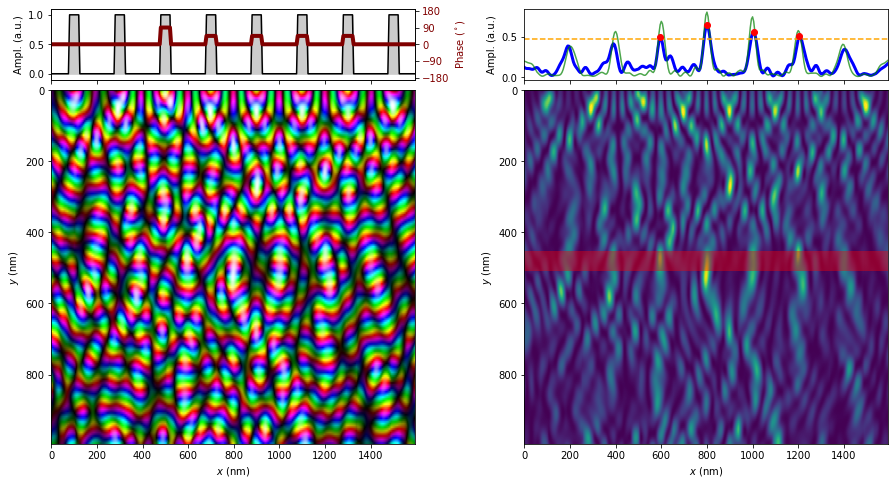

[0, 1, 1, 1, 1]

In [79]:
lookup_table_asymm(8, 200, 40, [3], pi/2, pi/4, 1, 1, 480, 0.47, True)
# 1) number of inputs
# 2) distance between inputs [nm]
# 3) inputs width [nm]
# 4) number (in sequence) of input to change
# 5) phase change of the chosen input [rad]
# 6) phase change of controls
# 7) amplitude change of the chosen input (if 1 --> unchanged)
# 8) amplitude change of controls
# 9) distance from inputs to analysis (#outputs = #inputs-1) [nm]
# 10) threshhold amplitude (a.u. --> from 0 to 1)
# 11) display plots (True) or just a truth table (False)

### 3 inputs (2 main and 1 control), 5 outputs configuration (as in the paper)

In [36]:
def logic_2_3_C1(I1_I2_C1):
    [I1,I2,C1] = I1_I2_C1
    return lookup_table_asymm(8, 200, 40, [2*I1,3*I2], pi/2, (pi/4)*C1, 1, 1, 480, 0.47, False)

In [37]:
number_of_inputs = 3
for i in range(len(inputs_combinations(number_of_inputs)[0])):
    output = logic_2_3_C1(inputs_combinations(number_of_inputs)[0][i])
    if inputs_combinations(number_of_inputs)[0][i][2]==0:
        print(i+1,')   ',inputs_combinations(number_of_inputs)[0][i],' --------> ',output) 
    else:
        print(i+1,')                                                ',inputs_combinations(number_of_inputs)[0][i],\
              ' --------> ',output)

1 )    [1, 0, 0]  -------->  [0, 0, 0, 1, 0]
2 )    [0, 1, 0]  -------->  [0, 0, 1, 0, 1]
3 )                                                 [0, 0, 1]  -------->  [1, 1, 1, 1, 0]
4 )    [1, 1, 0]  -------->  [0, 1, 1, 1, 1]
5 )                                                 [1, 0, 1]  -------->  [0, 1, 0, 1, 0]
6 )                                                 [0, 1, 1]  -------->  [0, 1, 1, 1, 1]
7 )                                                 [1, 1, 1]  -------->  [0, 1, 1, 1, 1]
